In [6]:
import warnings
#warnings.filterwarnings("error")
import os, sys
import numpy
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from fnmatch import fnmatch
import plotnine as p9
import patchworklib as pw

In [7]:
def model_prior():
    bcf = numpy.random.uniform(low=0,high=1)
    pi = numpy.random.uniform(low=0,high=1)
    cv = numpy.random.uniform(low=0,high=1)
    return numpy.array([bcf, pi, cv])

In [8]:
models = "trained_models"
param_nr = len(model_prior())
summary_parm = 16
inn_layer = 4
data_path = '/home/l/projects/Morpheus/Modelle/cell_free_50'
timesteps = 50
cut_off_start = 9
cut_off_end = 10

In [9]:
def calculate_V(path: str):
    df = pd.read_csv(path,sep='\t')
    df = df[df["10"]!=10]
    morpheus_ts = numpy.repeat(range(0,timesteps+1),10)
    times = numpy.tile(morpheus_ts,int(len(df.index)/morpheus_ts.shape[0]))
    if len(times) != len(df.index):
        print(path)
    df["time"] = numpy.tile(morpheus_ts,int(len(df.index)/morpheus_ts.shape[0]))
    df['sum_V'] = df.iloc[:, 1:11].sum(axis=1)
    df = df.drop(columns=[str(x) for x in range(0,11)])
    df = df.groupby(list(df.columns[:-1])).agg({'sum_V': 'sum'}).reset_index()
    return numpy.expand_dims(df['sum_V'],axis=1)[cut_off_start+1:timesteps-cut_off_end]

In [10]:
path_list= glob.glob(os.path.join(data_path, "output_well_mixed/*"))
nr_of_params = param_nr

n_sim = len(path_list)
dfs = numpy.empty((n_sim, (timesteps - 1 - cut_off_start - cut_off_end), 3), dtype=numpy.float32)
params = numpy.empty((n_sim, nr_of_params), dtype=numpy.float32)
invalidIndices = []

for path in range(n_sim):
    pathname = path_list[path]
    filename = os.path.join(pathname,'logger_2.csv')
    filename_V = os.path.join(pathname, 'logger_6_Ve.csv')
    df = pd.read_csv(filename, index_col=None, header=0, delimiter='\t')
    path_split = filename.split('/')[len(filename.split('/')) - 2]
    if path_split.startswith('sweep') or path_split.startswith('DV'):
        start_nr = 1
    else:
        start_nr = 0
    params_split = path_split.split('_')[start_nr:nr_of_params+1]
    param_file = list(map(lambda x: round(float(x.split('-')[1]),3), params_split))
    
    df_tar = df['celltype.target.size'].values[:, numpy.newaxis][cut_off_start+1:timesteps-cut_off_end]
    df_inf = df['celltype.infected.size'].values[:, numpy.newaxis][cut_off_start+1:timesteps-cut_off_end]
    df_cells = numpy.append(df_tar,df_inf,axis=1)
    df_V = calculate_V(filename_V)

    if numpy.any(df_inf<1) or numpy.any(numpy.asarray(param_file)>1) or len(df_inf) != (timesteps - 1 - cut_off_start - cut_off_end):
        invalidIndices.append(path)
        continue
    params[path] = param_file
    dfs[path] = numpy.append(df_cells,df_V,axis=1)
    
    #dfs[path] = df_inf[cut_off_start+1:timesteps-cut_off_end]
dfs = numpy.delete(dfs, invalidIndices, axis=0)
params = numpy.delete(params, invalidIndices, axis=0)    

In [11]:
def is_uninformative(array):
    is_uninformative = False 
    max_nr_t_cells = array[0,0]
    if(array[10,1] == 1 or array[10,0] == max_nr_t_cells):
        is_uninformative = True
    return is_uninformative 

In [12]:
def mask_uninformative(array):
    mask = [not is_uninformative(x) for x in array]
    return array[mask]

In [13]:
def count_informative_per_batch(data, batch_size):
    perm = numpy.random.permutation(data)
    split_idx = range(0,len(perm),batch_size)
    split = numpy.split(perm, split_idx)[1:]
    data_filtered = [mask_uninformative(a) for a in split]
    return numpy.array([len(a) for a in data_filtered])
    

In [17]:
batch_sizes = [16,32]
plots = []
for batch_size in batch_sizes:
    len_batch_filtered = count_informative_per_batch(dfs,batch_size)

    plot = (p9.ggplot(p9.aes(x=len_batch_filtered))
    + p9.geom_histogram(fill='grey',color='black', binwidth=1)
    + p9.xlab('Filtered batch size')
    + p9.theme_light()
    + p9.ggtitle('Batch size: ' + str(batch_size))
    + p9.scale_x_continuous(breaks = range(min(len_batch_filtered),max(len_batch_filtered)+1)))

    plots.append(pw.load_ggplot(plot))

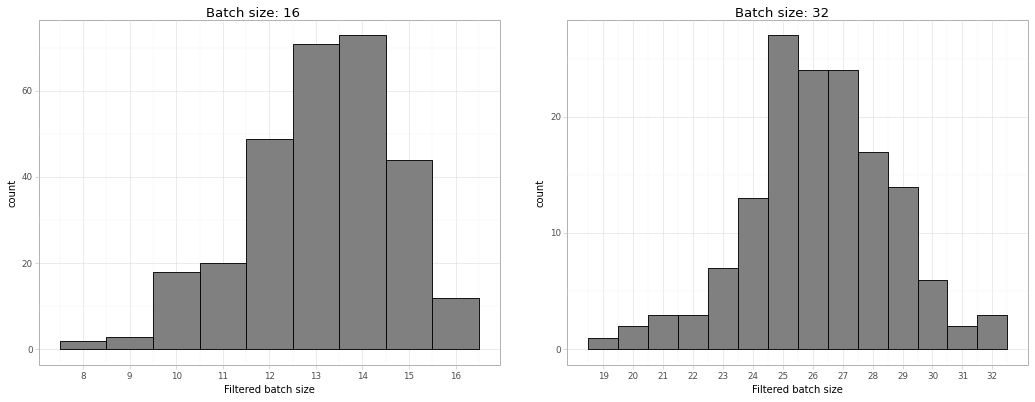

In [18]:
figure = ( plots[0] | plots[1] )
figure.savefig()